<a href="https://colab.research.google.com/github/lokeshtokas/SGEMM-GPU-Kernel-Performance/blob/main/SGEMM%20GPU%20Kernel%20Performance%20-%20Capstone%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the running times for multiplying two 2048 x 2048 matrices using a GPU OpenCL SGEMM kernel with varying parameters (using the library 'CLTune'). </u></b>

## <b> Problem Description </b>

### This data set measures the running time of a matrix-matrix product $A*B = C$, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds*.

### There are 14 parameter, the first 10 are ordinal and can only take up to 4 different powers of two values, and the 4 last variables are binary. Out of 1327104 total parameter combinations, only 241600 are feasible (due to various kernel constraints). This data set contains the results for all these feasible combinations.

### The experiment was run on a desktop workstation running Ubuntu 16.04 Linux with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB GF580 GTX-1.5GB GPU. We use the 'gemm_fast' kernel from the automatic OpenCL kernel tuning library 'CLTune' ([Web Link]).

#### * Note: for this kind of data sets it is usually better to work with the logarithm of the running times 


## <b> Data Description </b>

### <b>Attribute Information: </b>

### Independent variables:
* ### MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
* ### KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
* ### MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)
* ### MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)
* ### KWI: kernel loop unrolling factor: {2, 8} (integer)
* ### VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
* ### STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
* ### SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)

### Output:
* ### Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.

#Libraries

In [22]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
import plotly.graph_objects as go

# Data File

In [23]:
url = 'https://raw.githubusercontent.com/lokeshtokas/SGEMM-GPU-Kernel-Performance/main/data/sgemm_product.csv'

data = pd.read_csv(url)

In [24]:
data.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


# Data Wrangling

Merging all 4 run into a **'runtime'** column with mean value of all 4 run columns, and dropping them afterwards.

In [25]:
data['runtime'] = data[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].mean(axis=1)
data = data.drop(columns=['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'])

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 15 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   MWG      241600 non-null  int64  
 1   NWG      241600 non-null  int64  
 2   KWG      241600 non-null  int64  
 3   MDIMC    241600 non-null  int64  
 4   NDIMC    241600 non-null  int64  
 5   MDIMA    241600 non-null  int64  
 6   NDIMB    241600 non-null  int64  
 7   KWI      241600 non-null  int64  
 8   VWM      241600 non-null  int64  
 9   VWN      241600 non-null  int64  
 10  STRM     241600 non-null  int64  
 11  STRN     241600 non-null  int64  
 12  SA       241600 non-null  int64  
 13  SB       241600 non-null  int64  
 14  runtime  241600 non-null  float64
dtypes: float64(1), int64(14)
memory usage: 27.6 MB


**NULL Value Check**

In [27]:
data.isnull().sum()

MWG        0
NWG        0
KWG        0
MDIMC      0
NDIMC      0
MDIMA      0
NDIMB      0
KWI        0
VWM        0
VWN        0
STRM       0
STRN       0
SA         0
SB         0
runtime    0
dtype: int64

# EDA

**Checking statistical information of data using describe method.**

In [28]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
MWG,241600.0,80.415364,42.469220,16.0000,32.0000,64.00,128.0000,128.0000
NWG,241600.0,80.415364,42.469220,16.0000,32.0000,64.00,128.0000,128.0000
KWG,241600.0,25.513113,7.855619,16.0000,16.0000,32.00,32.0000,32.0000
MDIMC,241600.0,13.935894,7.873662,8.0000,8.0000,8.00,16.0000,32.0000
NDIMC,241600.0,13.935894,7.873662,8.0000,8.0000,8.00,16.0000,32.0000
MDIMA,241600.0,17.371126,9.389418,8.0000,8.0000,16.00,32.0000,32.0000
NDIMB,241600.0,17.371126,9.389418,8.0000,8.0000,16.00,32.0000,32.0000
KWI,241600.0,5.000000,3.000006,2.0000,2.0000,5.00,8.0000,8.0000
VWM,241600.0,2.448609,1.953759,1.0000,1.0000,2.00,4.0000,8.0000
VWN,241600.0,2.448609,1.953759,1.0000,1.0000,2.00,4.0000,8.0000


**We can notice that for 'runtime' data, the first 3 quratiles are 40, 70 and 239 respectively. But some of our values reach to the far end of 3341.**

**Checking for outliers in 'runtime'**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


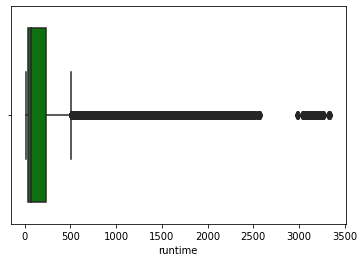

In [29]:
sns.boxplot(data['runtime'],color='green')
plt.show()

From the above plot we can deduce that there are no extreme outliers and that the entire data is usefull.

**Heatmap to check data for correlation**

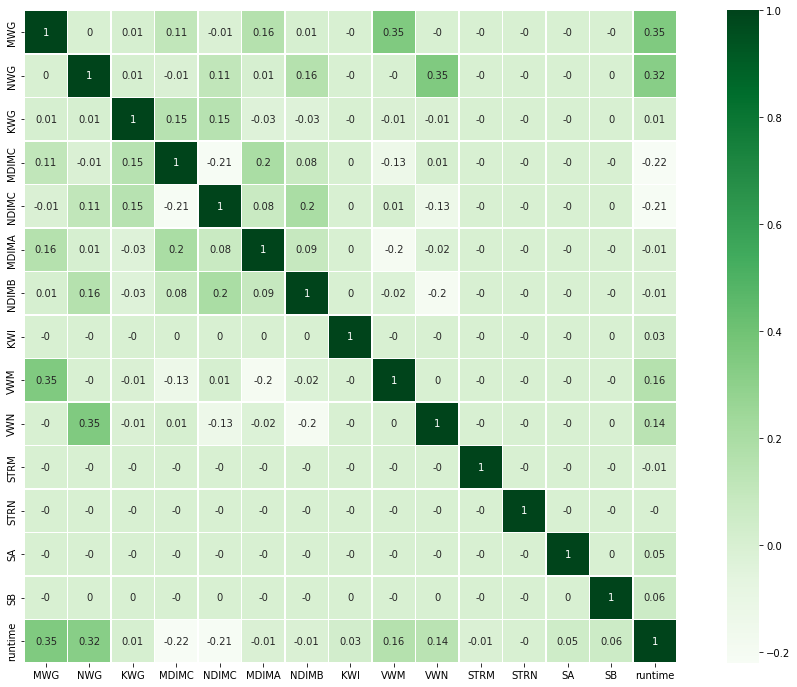

In [30]:
plt.figure(figsize=(18,12))
sns.heatmap(round(data.corr(),2),cmap="Greens",annot=True, square = True,linewidths=.5)
plt.show()

**Observation :** No Significant correlation found with max at 0.35, hence we have a good data

Creating histogram for every column.

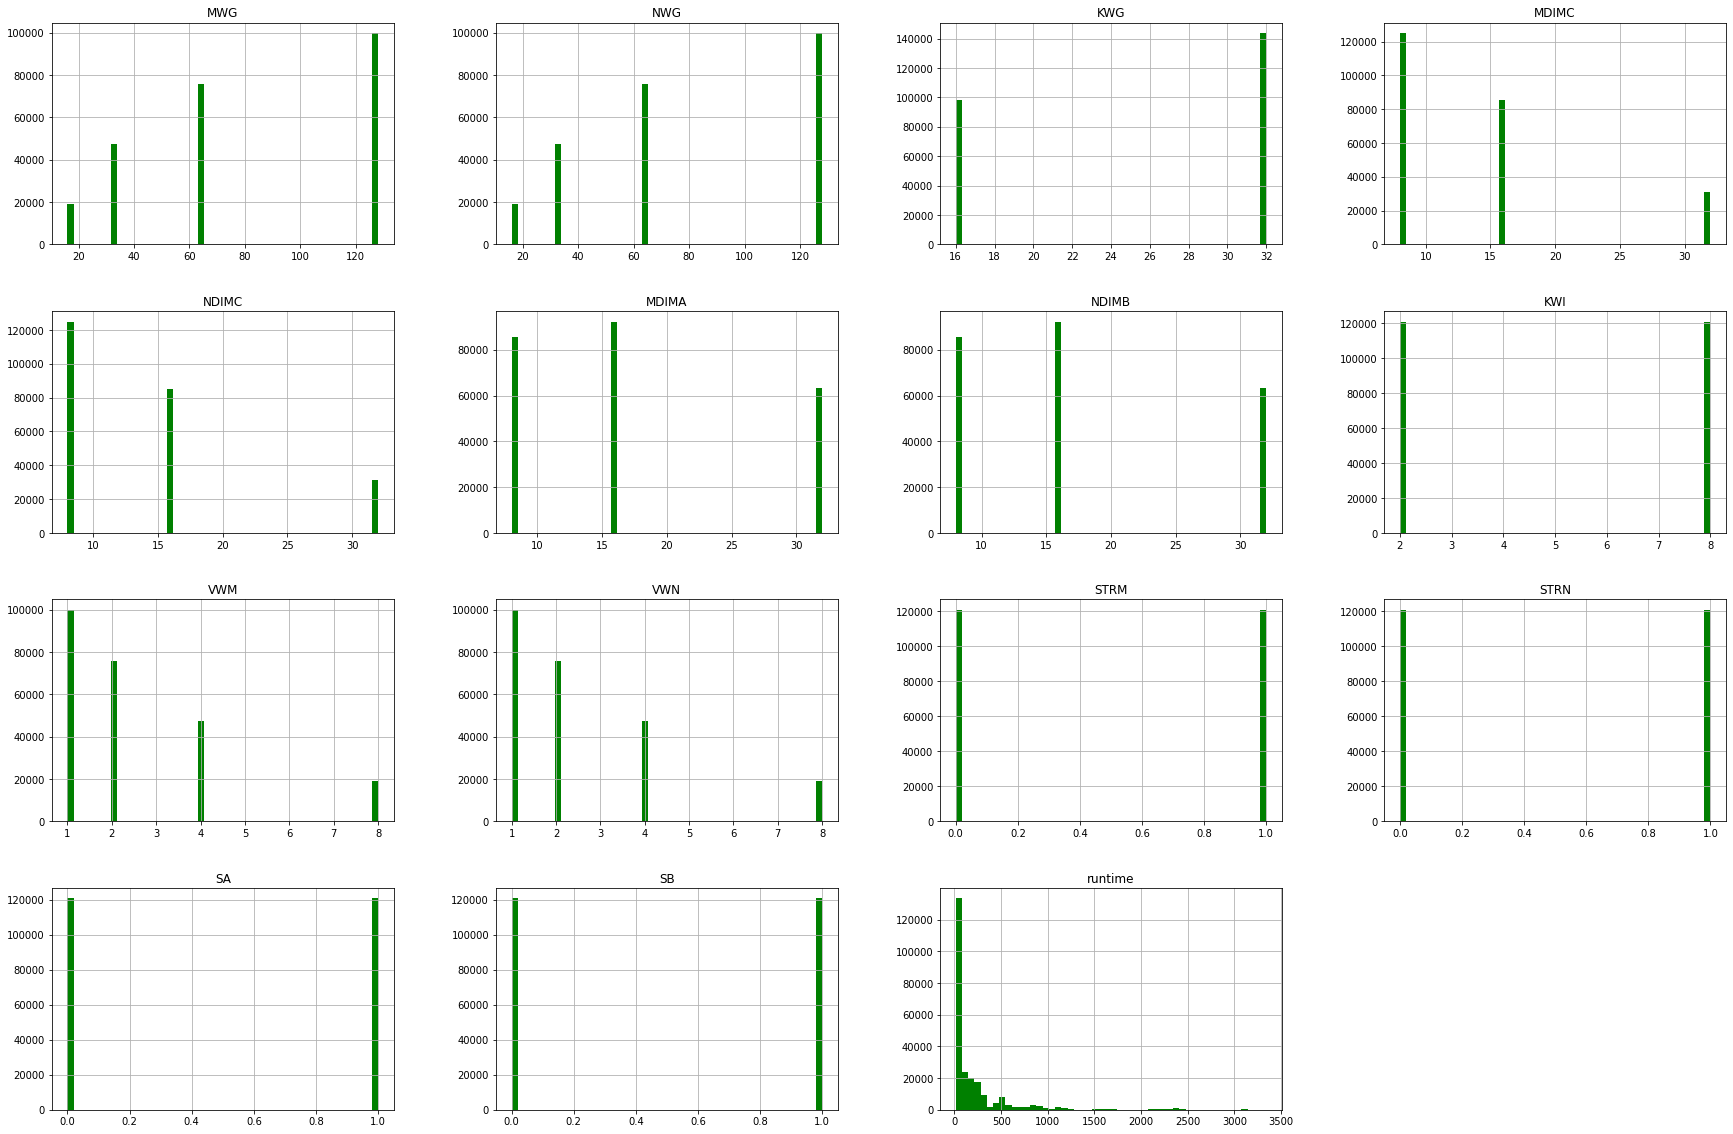

In [31]:
data.hist(bins = 50, figsize = (30,20),color='green')
plt.show()

**Checking Skewness of 'runtime'**

In [32]:
data['runtime'].skew()

3.9254459949969687

-runtime is right/positive skew, checking with graph

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


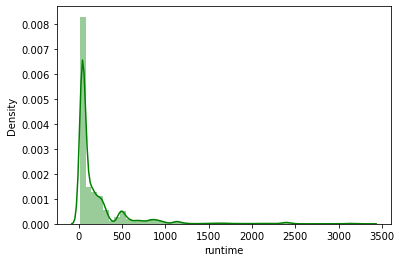

In [33]:
sns.distplot(data['runtime'],color='green')
plt.show()

**Transforming 'runtime' data by scaling it with log for normalisation**

In [34]:
#creating a 'Target runtime' to store tranformed values
data['Target runtime'] = np.log(data['runtime'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


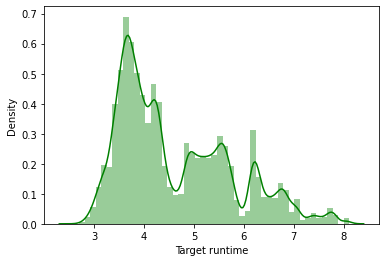

In [35]:
sns.distplot(data['Target runtime'],color='green')
plt.show()

Now data is looking bit more normalised.

Checking if tranformation was successfull if **'Target runtime'** & **'runtime'** are correlated.

In [36]:
corr_check = data.corr()
corr_check['Target runtime']

MWG               0.459029
NWG               0.346429
KWG              -0.020358
MDIMC            -0.252085
NDIMC            -0.243448
MDIMA            -0.023076
NDIMB            -0.033688
KWI              -0.011200
VWM               0.209574
VWN               0.145031
STRM             -0.058792
STRN             -0.007790
SA               -0.084739
SB               -0.020323
runtime           0.809856
Target runtime    1.000000
Name: Target runtime, dtype: float64

Heatmap check for correaltion

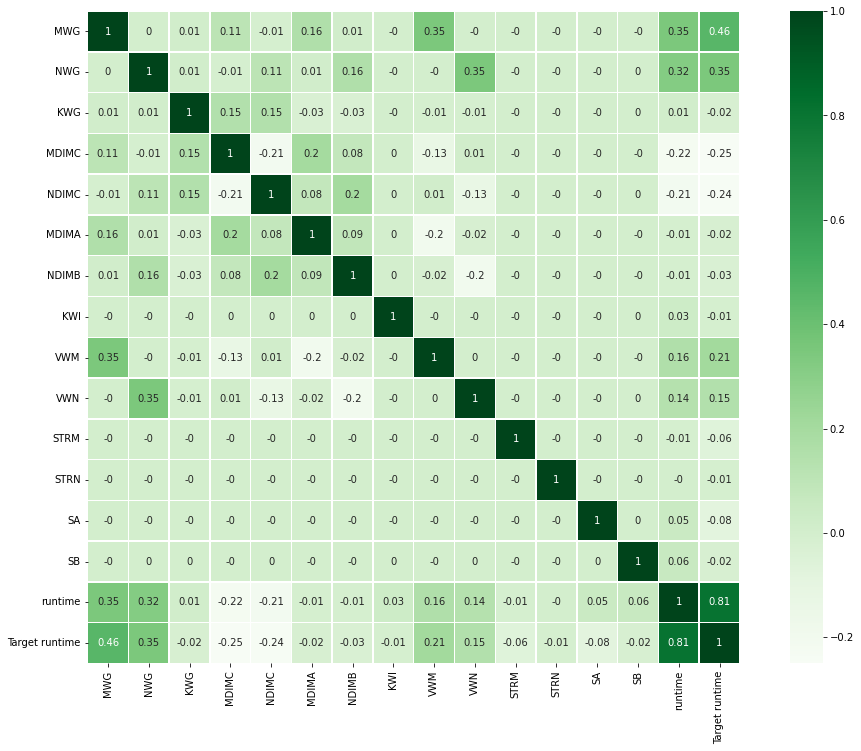

In [37]:
plt.figure(figsize=(18,12))
sns.heatmap(round(data.corr(),2),cmap="Greens",annot=True, square = True,linewidths=.5)
plt.show()

**'Target runtime'** is correlated to **'runtime'** and no other correlation observed, Hence transformation is relivant and a good data for ML

#Machine Learning